<a href="https://colab.research.google.com/github/j2damax/ml-learning-journey/blob/main/pytorch-deep-learning/02_fully_connected_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jayampathy Balasuriya - COMScDS242P-009@student.nibm.lk
# 02-08-2025

# Fully Connected Neural Network for MNIST Classification using PyTorch

In this notebook, we will walk through the process of building, training, and evaluating a fully connected neural network for classifying handwritten digits from the MNIST dataset using PyTorch. We'll cover data loading and preprocessing, model definition, training, evaluation, and visualization of the results.

In [2]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Step 1: Data Loading and Preprocessing

We'll start by defining the transformations to apply to the images and loading the MNIST dataset.

#### MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The dataset contains 70,000 images of handwritten digits (0-9) with 60,000 images in the training set and 10,000 images in the test set. Each image is a 28x28 grayscale image, meaning each pixel value ranges from 0 (black) to 255 (white). The dataset is well-suited for training and testing machine learning models in image recognition tasks, and it has become a standard benchmark for evaluating algorithms.



#### torch.utils.data.DataLoader

torch.utils.data.DataLoader is a utility in PyTorch that provides an efficient way to load and preprocess data. It allows for easy batching, shuffling, and parallel data loading using multiple workers. Key features include:

1. `Batching`: Automatically groups data into batches.
2. `Shuffling`: Randomizes the order of data samples, which is important for training neural networks.
3. `Parallel Loading`: Utilizes multiple CPU cores to load data in parallel, reducing the time spent on data loading.

DataLoader is essential for handling large datasets and ensuring efficient data feeding during the training and evaluation of models.

In [3]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values with mean and std
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]


# Step 2: Exploratory Data Analysis (EDA)

Let's visualize some sample images from the MNIST dataset.

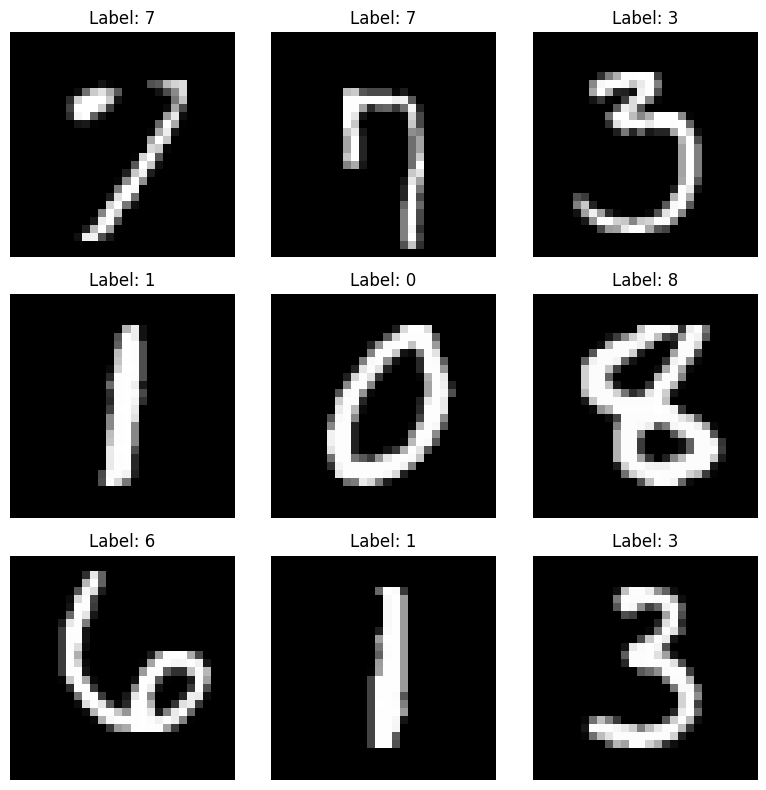

In [4]:
# Visualize some sample images
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f'Label: {example_targets[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Step 3: Define the Neural Network Model

We will define a simple fully connected neural network with two layers.


#### torch.nn Module

The `torch.nn` module in PyTorch provides a wide range of classes and functions to help you build neural networks. It includes pre-defined layers, activation functions, loss functions, and utilities that can be used to define and train neural networks. Some key components include:

1. `Layers`: nn.Linear, nn.Conv2d, nn.RNN, etc., to define various types of neural network layers.
2. `Activations`: nn.ReLU, nn.Sigmoid, nn.Tanh, etc., to introduce non-linearities in the network.
3. `Loss Functions`: nn.CrossEntropyLoss, nn.MSELoss, etc., to calculate the loss during training.
4. `Container Modules`: nn.Sequential, nn.ModuleList, nn.ModuleDict, to organize and manage layers.

Overall, torch.nn provides the building blocks for creating and training neural networks in PyTorch.

In [5]:
# Define the neural network model
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()

        # First Layer
        self.layer_1 = nn.Linear(28*28, 512)
        self.activation_1 = nn.ReLU() # ReLU activation

        # Second layer
        self.layer_2 = nn.Linear(512, 10)

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28*28)

        # Calling the first layer
        x = self.layer_1(x)
        x = self.activation_1(x)

        # Calling the second layer
        x = self.layer_2(x)  # Output layer
        return x

# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNet().to(device)
print(model)

FullyConnectedNet(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (activation_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=10, bias=True)
)


# Step 4: Define the Loss Function and Optimizer

We'll use cross-entropy loss and stochastic gradient descent (SGD) optimizer.

#### CrossEntropyLoss

CrossEntropyLoss is a commonly used loss function for classification problems in neural networks. It combines LogSoftmax and NLLLoss (negative log-likelihood loss) in a single class. CrossEntropyLoss is particularly useful for multi-class classification tasks.

#### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is an optimization algorithm used to minimize the loss function during the training of a machine learning model. Unlike traditional gradient descent, which computes the gradient of the loss function using the entire training dataset, SGD updates the model parameters using only a single training example or a small batch of examples at each iteration. This makes SGD more efficient and able to handle large datasets. Key features of SGD include:

* Efficiency: Faster convergence on large datasets.
* Stochastic Nature: Introduces noise in the parameter updates, which can help in escaping local minima.
* Adjustable Learning Rate: Allows tuning of the learning rate to control the step size of parameter updates.



In [6]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Step 5: Training the Model

Let's define the training loop.

In [7]:
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

running_loss = 0.0
running_acc = 0.0

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    global running_loss
    global running_acc
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

# Track training loss and accuracy
train_losses = []
train_accuracies = []

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_acc / len(train_loader))


Epoch 1, Batch 200, Loss: 1.0885, Accuracy: 0.7679
Epoch 1, Batch 400, Loss: 0.5021, Accuracy: 0.8705
Epoch 1, Batch 600, Loss: 0.3873, Accuracy: 0.8941
Epoch 1, Batch 800, Loss: 0.3604, Accuracy: 0.8980
Epoch 2, Batch 200, Loss: 0.5516, Accuracy: 0.9131
Epoch 2, Batch 400, Loss: 0.2936, Accuracy: 0.9153
Epoch 2, Batch 600, Loss: 0.2888, Accuracy: 0.9193
Epoch 2, Batch 800, Loss: 0.2688, Accuracy: 0.9220
Epoch 3, Batch 200, Loss: 0.4598, Accuracy: 0.9277
Epoch 3, Batch 400, Loss: 0.2371, Accuracy: 0.9335
Epoch 3, Batch 600, Loss: 0.2407, Accuracy: 0.9291
Epoch 3, Batch 800, Loss: 0.2348, Accuracy: 0.9334
Epoch 4, Batch 200, Loss: 0.3882, Accuracy: 0.9346
Epoch 4, Batch 400, Loss: 0.2094, Accuracy: 0.9407
Epoch 4, Batch 600, Loss: 0.2037, Accuracy: 0.9428
Epoch 4, Batch 800, Loss: 0.1989, Accuracy: 0.9459
Epoch 5, Batch 200, Loss: 0.3119, Accuracy: 0.9515
Epoch 5, Batch 400, Loss: 0.1962, Accuracy: 0.9448
Epoch 5, Batch 600, Loss: 0.1824, Accuracy: 0.9517
Epoch 5, Batch 800, Loss: 0.185

# Step 6: Evaluating the Model

We'll define a function to evaluate the model on the test dataset.

In [8]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}')
    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)


Test Loss: 0.1154, Test Accuracy: 0.9662


# Step 7: Visualizing Training Progress

Let's plot the training loss and accuracy over the epochs.

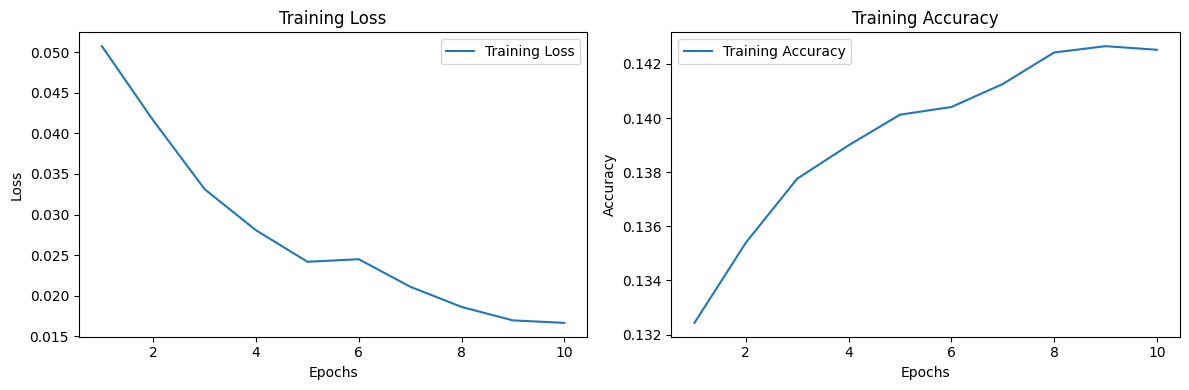

In [9]:
# Plot training loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 8: Confusion Matrix

We'll plot the confusion matrix to see how well the model is performing across different classes.

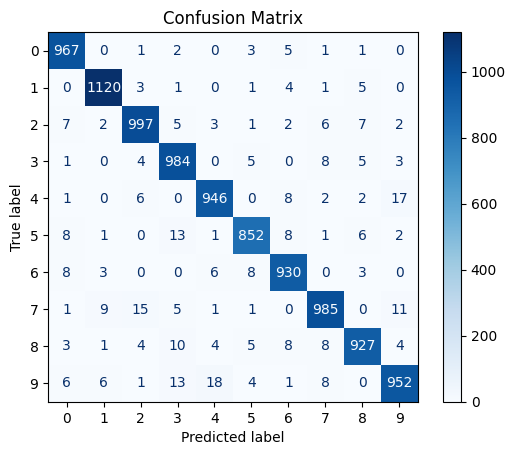

In [10]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Step 9: Visualizing Predictions

Finally, let's visualize some sample predictions from the model.

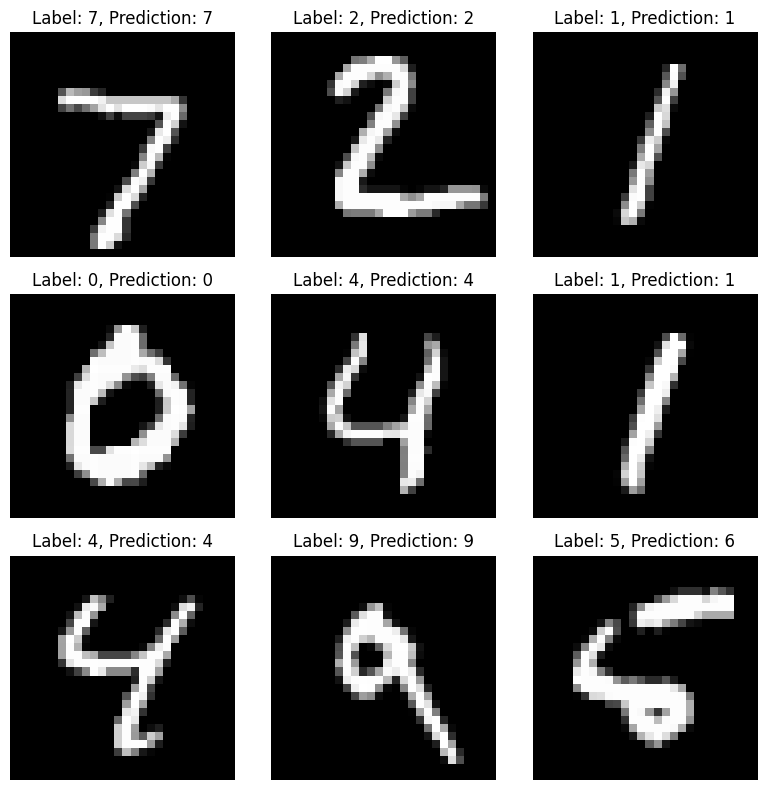

In [11]:
# Visualize some sample images and predictions
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)
outputs = model(samples)
_, preds = torch.max(outputs, 1)
samples = samples.cpu().numpy()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}, Prediction: {preds[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Let's display some examples where the model made incorrect predictions.

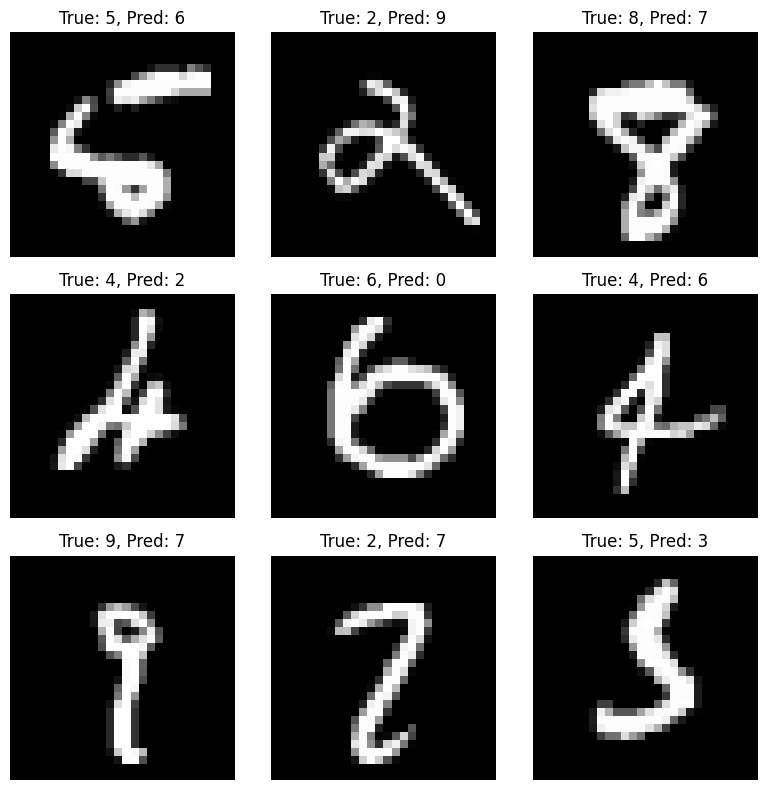

In [12]:
# Visualize incorrect predictions
incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    idx = incorrect[i]
    ax.imshow(test_loader.dataset[idx][0][0], cmap='gray')
    ax.set_title(f'True: {all_labels[idx]}, Pred: {all_preds[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


# 10. Conclusion

In this notebook, we have built a simple fully connected neural network for classifying MNIST digits using PyTorch. We covered data loading, preprocessing, model definition, training, evaluation, and visualization of results. This provides a good foundation for understanding the process of developing neural network models for image classification tasks.